In [1]:
from help_funcs import *

seed 0
	made raster
in
	getting count and rankvecs...
	count optimization ...
	rank optimization


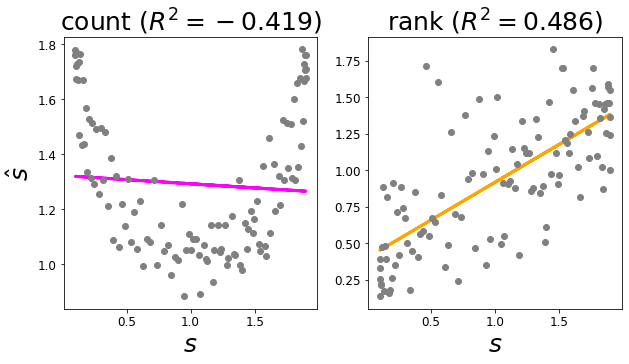

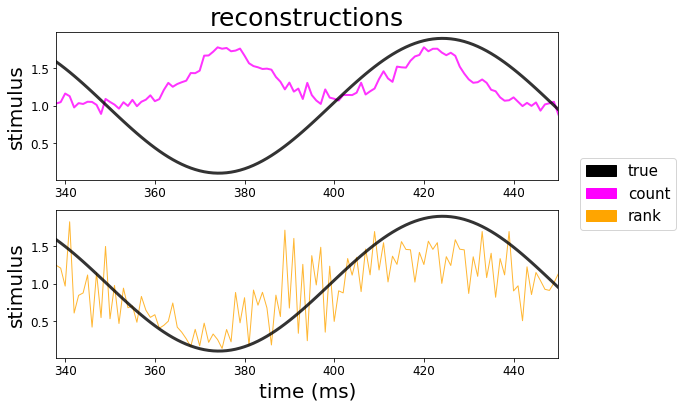

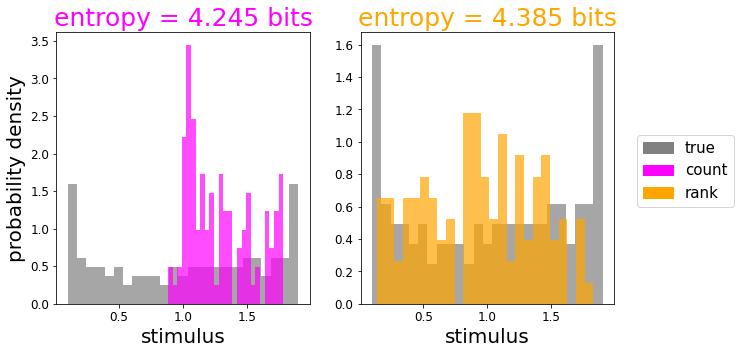

E1
	getting count and rankvecs...
	count optimization ...
	rank optimization


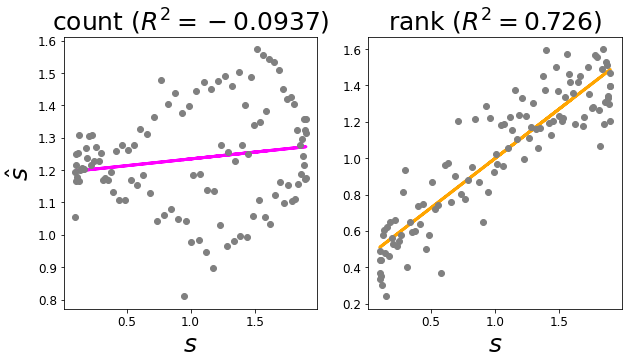

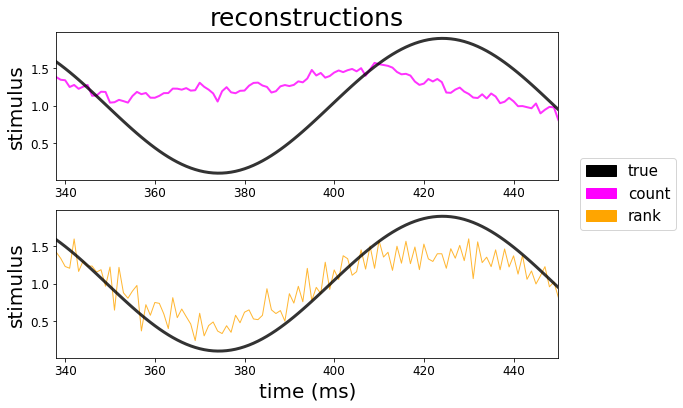

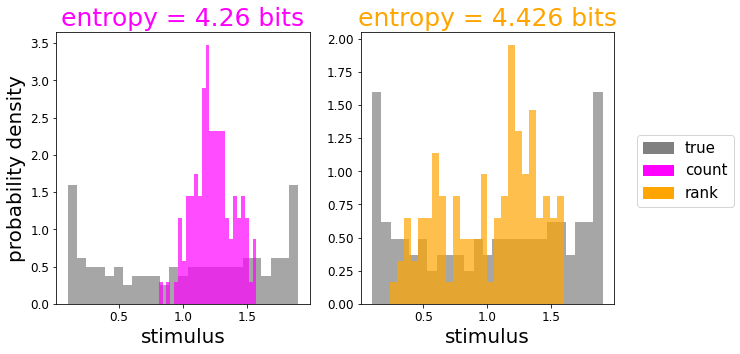

B
	getting count and rankvecs...
	count optimization ...
	rank optimization


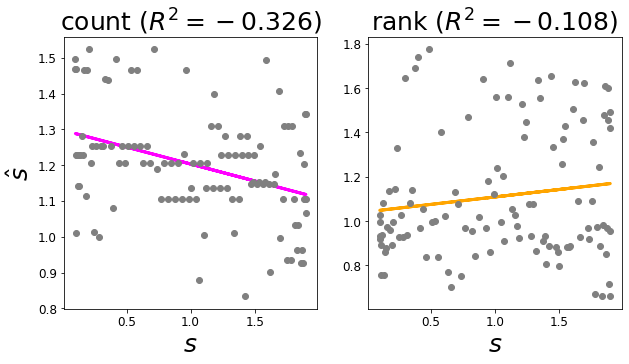

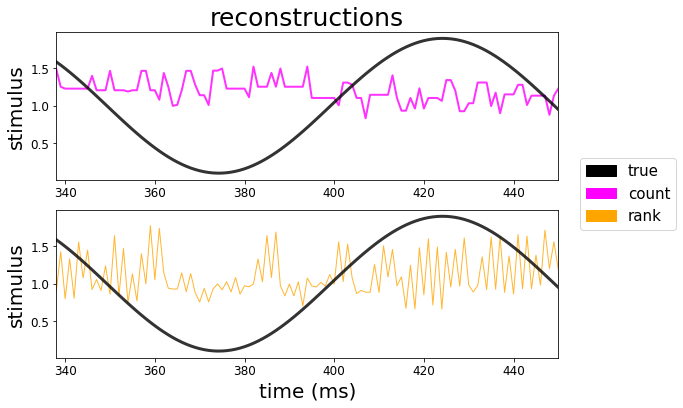

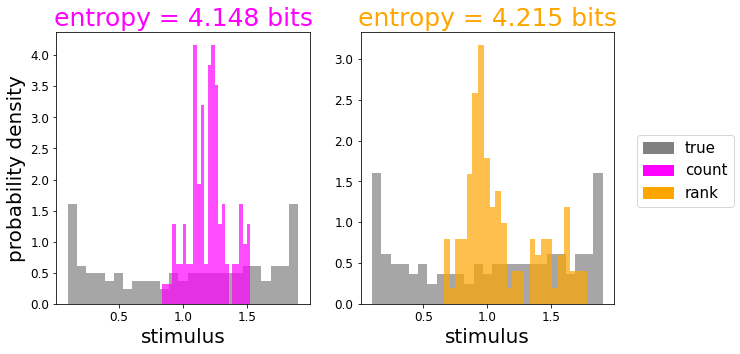

E2
	getting count and rankvecs...
	count optimization ...
	rank optimization


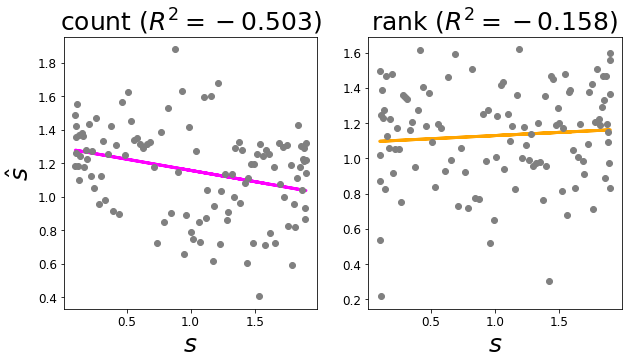

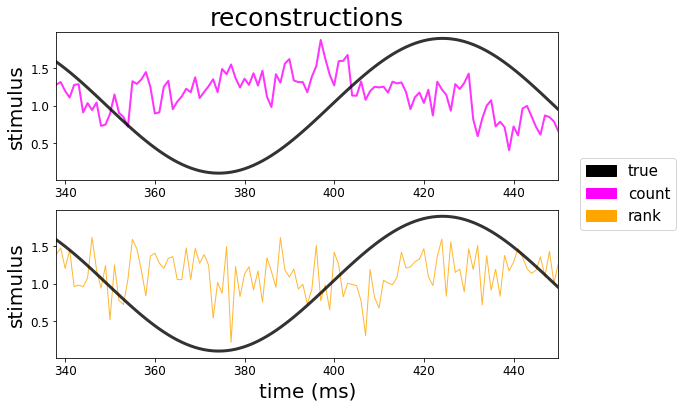

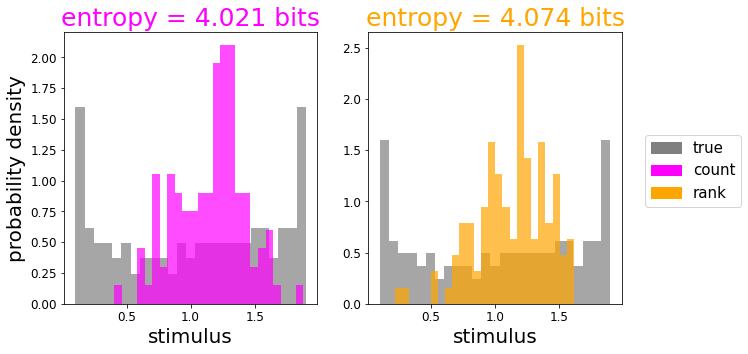

out
	getting count and rankvecs...
	count optimization ...
	rank optimization


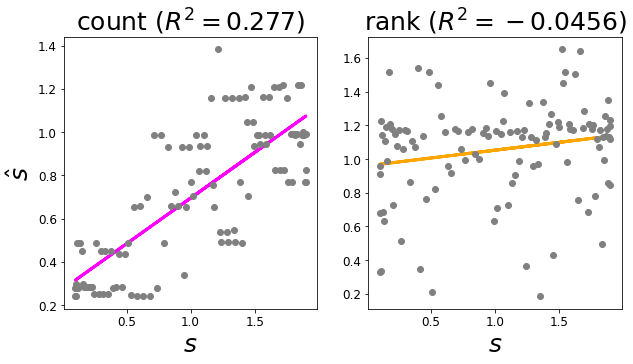

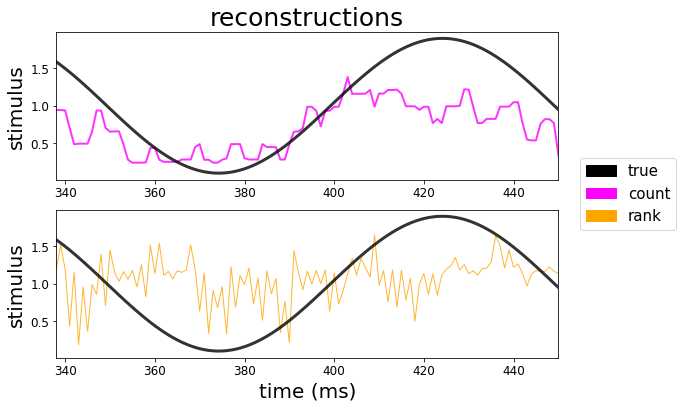

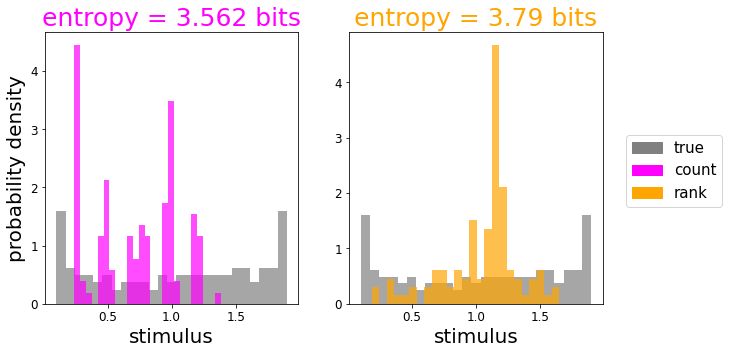

finished decoding all layers for seed 0

seed 1
	made raster
in
	getting count and rankvecs...
	count optimization ...
	rank optimization


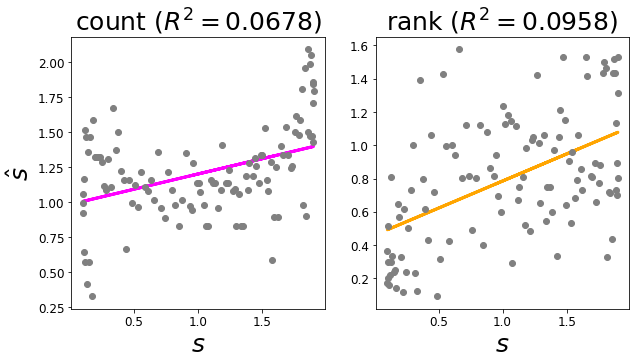

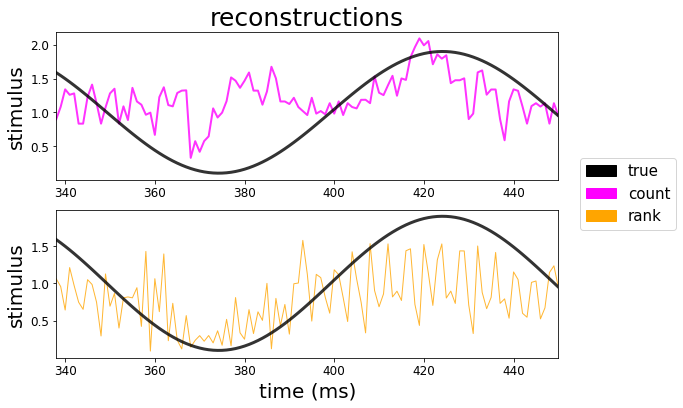

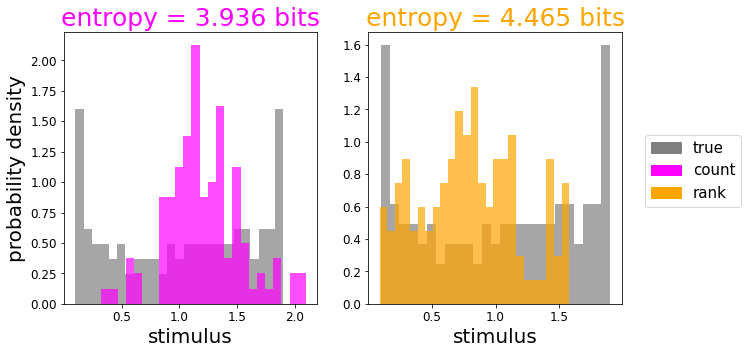

E1
	getting count and rankvecs...
	count optimization ...
	rank optimization


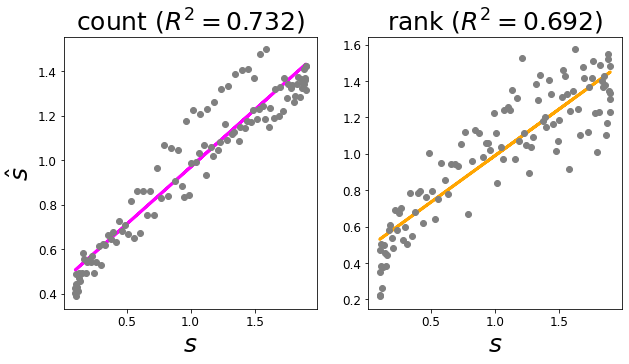

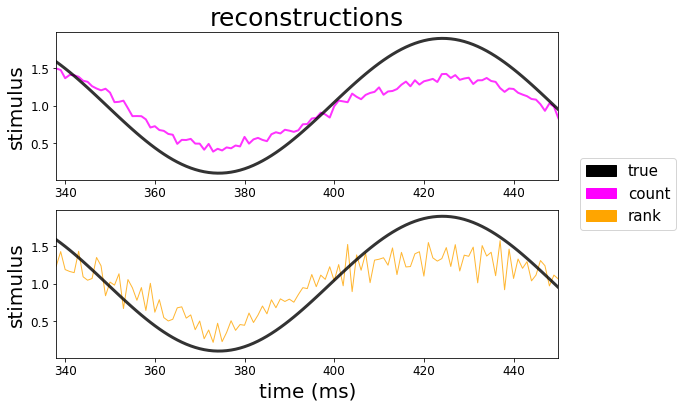

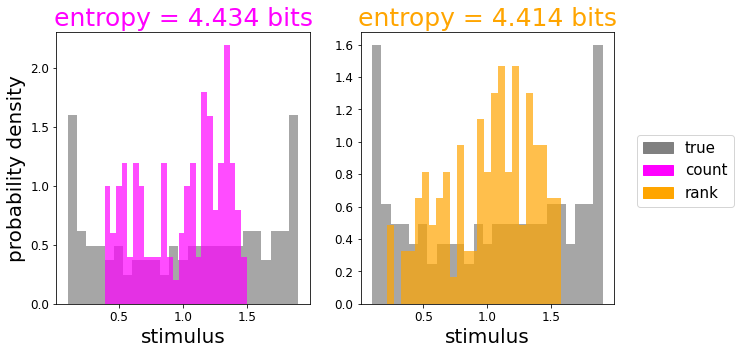

B
	getting count and rankvecs...
	count optimization ...
	rank optimization


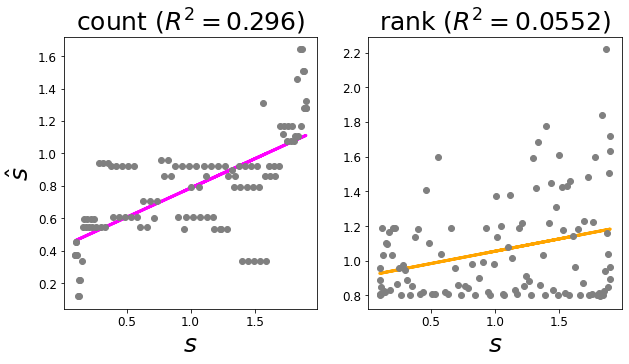

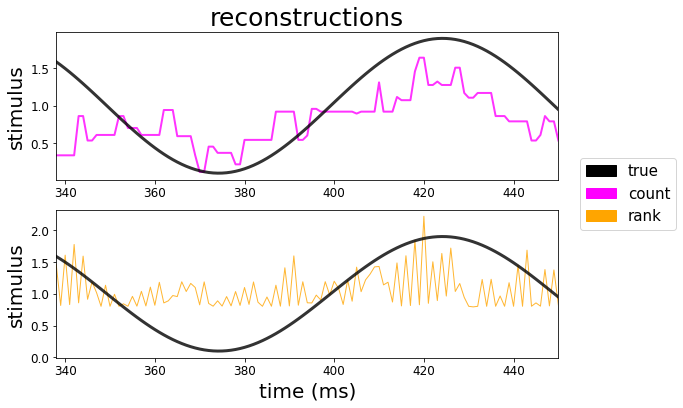

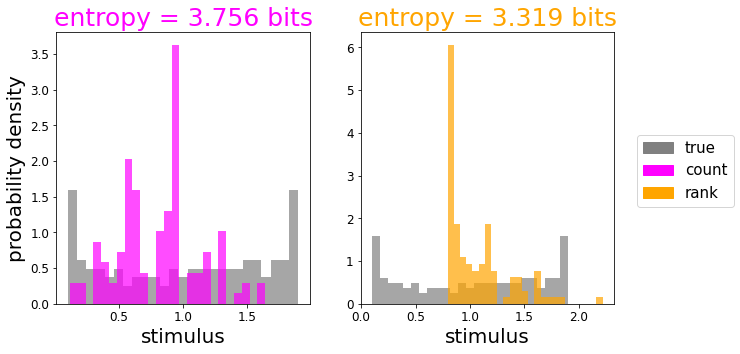

E2
	getting count and rankvecs...
	count optimization ...
	rank optimization


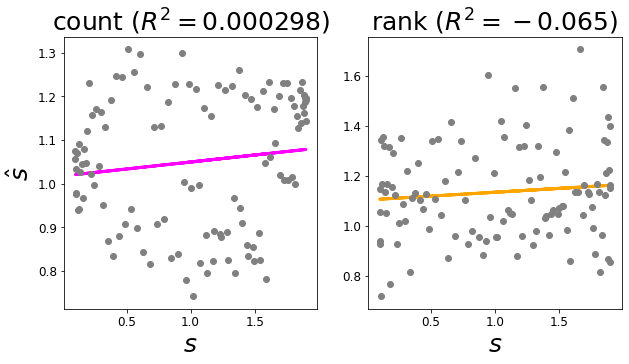

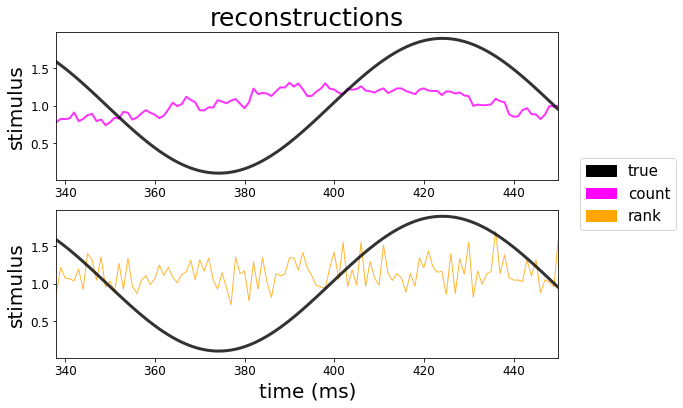

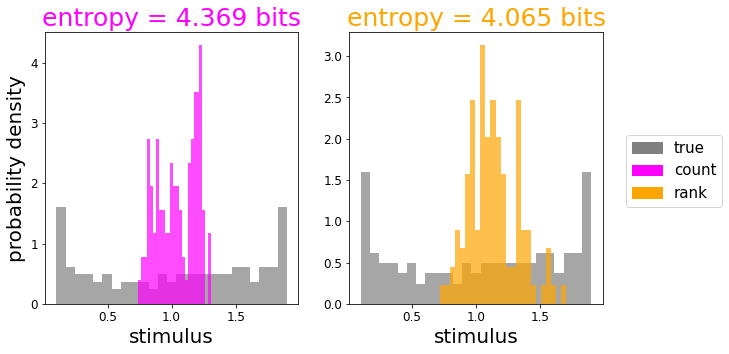

out
	getting count and rankvecs...
	count optimization ...
	rank optimization


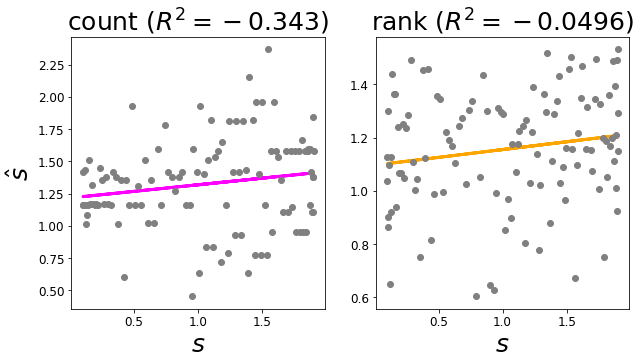

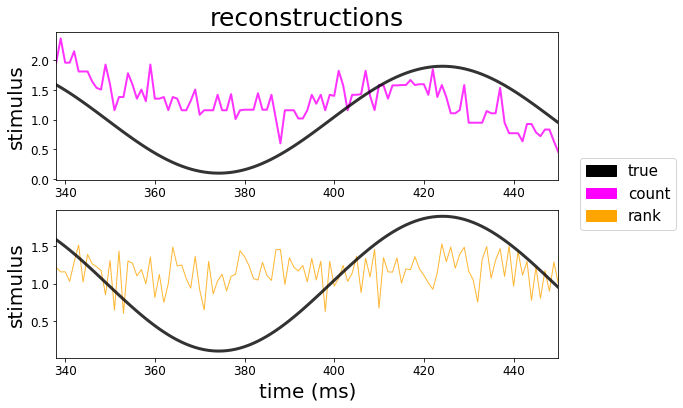

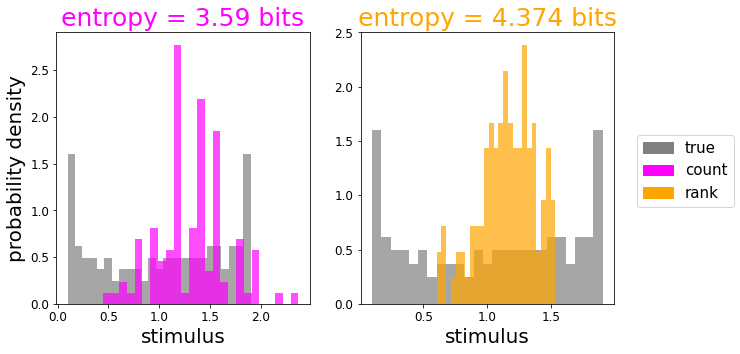

finished decoding all layers for seed 1



In [2]:
# RUN THE MODEL

Nin = 10
NE1 = 1000
NB = 10
NE2 = 100
Nout = 10
Ns = [Nin, NE1, NB, NE2, Nout]
layerNames = ['in', 'E1', 'B', 'E2', 'out']
N_nrnVec = [Nin, NE1, NB, NE2, Nout]
numLayers = len(layerNames)
num_steps = 500
tf = num_steps
dt = 1
tvec = np.arange(0,tf,dt)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tf = num_steps
T_R = 50
delay = 0
delta_t = 2
train_frac = 0.5
slideVec = np.arange(0,tf-T_R+dt,dt)

######################################################################
num_samples = 1
mode = "sine" # 'linear' or 'sqrt'
batch_size = 1 # only one sample to learn
######################################################################

numseeds = 2

r2_tr_c_allseeds_pre = np.zeros((numseeds,numLayers))
r2_te_c_allseeds_pre = np.zeros((numseeds,numLayers))
r2_tr_r_allseeds_pre = np.zeros((numseeds,numLayers))
r2_te_r_allseeds_pre = np.zeros((numseeds,numLayers))
mi_c_allseeds_pre = np.zeros((numseeds,numLayers))
mi_r_allseeds_pre = np.zeros((numseeds,numLayers))
ent_c_allseeds_pre = np.zeros((numseeds,numLayers))
ent_r_allseeds_pre = np.zeros((numseeds,numLayers))

for seednum in range(numseeds):
    print(f'seed {seednum}')
    torch.manual_seed(seednum)
    random.seed(seednum)
    np.random.seed(seednum)
    dataset = RegressionDataset(timesteps=num_steps, num_samples=num_samples, 
                                mode=mode)

    dataloader = torch.utils.data.DataLoader(dataset=dataset, 
                                             batch_size=batch_size, 
                                             drop_last=True)

    model = ConDivNet(timesteps=num_steps, Nin=Nin, NE1=NE1, NB=NB, NE2=NE2, Nout=Nout).to(device)
    train_batch = iter(dataloader)
    with torch.no_grad():
        for feature, label in train_batch:
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(device)
            label = label.to(device)
            mem, spk_in_rec, spk_E1_rec, spk_B_rec, spk_E2_rec, spk_out_rec = model(label)

    tag = 'preTrain'
    plotFit(mem, label, seednum, tag)
    model_params = list(model.named_parameters())
    makeWtPlots(model_params,tag,seednum)

    spk_in_rec_re = np.reshape(spk_in_rec,(num_steps,Nin))
    in_spks = np.array(spk_in_rec_re.cpu(),dtype=bool)
    stin, siin = np.where(in_spks == True)

    spk_E1_rec_re = np.reshape(spk_E1_rec,(num_steps,NE1))
    E1_spks = np.array(spk_E1_rec_re.cpu(),dtype=bool)
    stE1, siE1 = np.where(E1_spks == True)

    spk_B_rec_re = np.reshape(spk_B_rec,(num_steps,NB))
    B_spks = np.array(spk_B_rec_re.cpu(),dtype=bool)
    stB, siB = np.where(B_spks == True)

    spk_E2_rec_re = np.reshape(spk_E2_rec,(num_steps,NE2))
    E2_spks = np.array(spk_E2_rec_re.cpu(),dtype=bool)
    stE2, siE2 = np.where(E2_spks == True)

    spk_out_rec_re = np.reshape(spk_out_rec,(num_steps,Nout))
    out_spks = np.array(spk_out_rec_re.cpu(),dtype=bool)
    stout, siout = np.where(out_spks == True)

    spikeTimes = [stin, stE1, stB, stE2, stout]
    spikeIndices = [siin, siE1, siB, siE2, siout]
    stim = label[:, 0, :].cpu()
    outVolts = mem[:, 0, :].cpu()

    makeRaster(Ns, stim, spikeTimes, spikeIndices, outVolts, seednum, tag)
    print('\tmade raster')
    
#     allSpikeTimes = [stin, stE1, stB, stE2, stout]
#     allSpikeIndices = [siin, siE1, siB, siE2, siout]

    num_times = len(slideVec)
    stimSub = label[:, 0, :][:num_times]
    tvecSub = tvec[:num_times]
    y = np.array(stimSub)
    y = np.reshape(y,(len(y),))
    stim = y

    r2_tr_c_all = []
    r2_te_c_all = []
    r2_tr_r_all = []
    r2_te_r_all = []
    mi_c_all = []
    mi_r_all = []
    ent_c_all = []
    ent_r_all = []

    # path = tag
    for li in range(numLayers):
        layerName = layerNames[li]
        print(layerName)
        N_nrn = N_nrnVec[li]
        st = spikeTimes[li]
        si = spikeIndices[li]

        fitMetrics, data = getCorrPlots(st,si,stim,N_nrn,tf,T_R,dt,delta_t,
                                                seednum,delay,layerName,tag)
        r2_tr_c, r2_te_c, r2_tr_r, r2_te_r, mi_c, mi_r = fitMetrics
        y_test, y_pred_count, y_pred_rank = data
        getReconstruction(tvecSub,y_test,y_pred_count,y_pred_rank,layerName,tag,seednum)
        true_ent, count_ent, rank_ent = getStimDist(y_test,y_pred_count,y_pred_rank,layerName,tag,seednum)

        r2_tr_c_all.append(r2_tr_c)
        r2_te_c_all.append(r2_te_c)
        r2_tr_r_all.append(r2_tr_r)
        r2_te_r_all.append(r2_te_r)
        mi_c_all.append(mi_c)
        mi_r_all.append(mi_r)
        ent_c_all.append(count_ent)
        ent_r_all.append(rank_ent)
        
    r2_tr_c_allseeds_pre[seednum,:] = np.array(r2_tr_c_all)
    r2_te_c_allseeds_pre[seednum,:] = np.array(r2_te_c_all)
    r2_tr_r_allseeds_pre[seednum,:] = np.array(r2_tr_r_all)
    r2_te_r_allseeds_pre[seednum,:] = np.array(r2_te_r_all)
    mi_c_allseeds_pre[seednum,:] = np.array(mi_c_all)
    mi_r_allseeds_pre[seednum,:] = np.array(mi_r_all)
    ent_c_allseeds_pre[seednum,:] = np.array(ent_c_all)
    ent_r_allseeds_pre[seednum,:] = np.array(ent_r_all)
        
    print(f'finished decoding all layers for seed {seednum}\n')
    

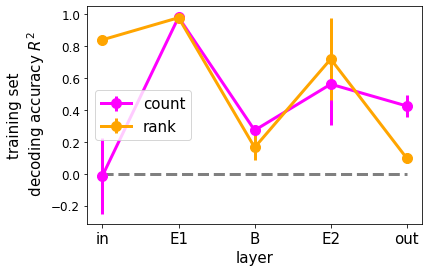

In [3]:
layerVec = np.arange(0,numLayers,1)
layerLabels = ['in','E1','B','E2','out']
countR2s_mean_tr = np.mean(r2_tr_c_allseeds_pre,axis=0)
countR2s_sd_tr = np.std(r2_tr_c_allseeds_pre,axis=0)
rankR2s_mean_tr = np.mean(r2_tr_r_allseeds_pre,axis=0)
rankR2s_sd_tr = np.std(r2_tr_r_allseeds_pre,axis=0)
plt.errorbar(layerVec,countR2s_mean_tr,countR2s_sd_tr,label='count',marker='o',linewidth=3,markersize=10,color='magenta')
plt.errorbar(layerVec,rankR2s_mean_tr,rankR2s_sd_tr,label='rank',marker='o',linewidth=3,markersize=10,color='orange')
plt.plot(layerVec,np.zeros(numLayers),color='gray',linestyle='--',linewidth=3)
plt.xticks(layerVec,layerLabels,fontsize=15)
plt.yticks(fontsize=12)
plt.ylabel('training set\n decoding accuracy $R^2$',fontsize=15)
plt.xlabel('layer',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('trainR2_v_layer_2seeds.png',bbox_inches='tight',dpi=200)
plt.show()

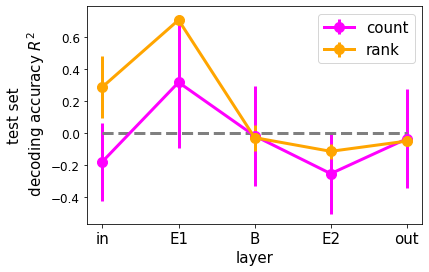

In [4]:
layerVec = np.arange(0,numLayers,1)
layerLabels = ['in','E1','B','E2','out']
countR2s_mean_te = np.mean(r2_te_c_allseeds_pre,axis=0)
countR2s_sd_te = np.std(r2_te_c_allseeds_pre,axis=0)
rankR2s_mean_te = np.mean(r2_te_r_allseeds_pre,axis=0)
rankR2s_sd_te = np.std(r2_te_r_allseeds_pre,axis=0)
plt.errorbar(layerVec,countR2s_mean_te,countR2s_sd_te,label='count',marker='o',linewidth=3,markersize=10,color='magenta')
plt.errorbar(layerVec,rankR2s_mean_te,rankR2s_sd_te,label='rank',marker='o',linewidth=3,markersize=10,color='orange')
plt.plot(layerVec,np.zeros(numLayers),color='gray',linestyle='--',linewidth=3)
plt.xticks(layerVec,layerLabels,fontsize=15)
plt.yticks(fontsize=12)
plt.ylabel('test set\n decoding accuracy $R^2$',fontsize=15)
plt.xlabel('layer',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('testR2_v_layer_2seeds.png',bbox_inches='tight',dpi=200)
plt.show()

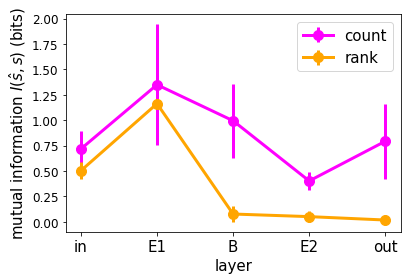

In [5]:
mi_c_mean = np.mean(mi_c_allseeds_pre,axis=0)
mi_c_sd = np.std(mi_c_allseeds_pre,axis=0)
mi_r_mean = np.mean(mi_r_allseeds_pre,axis=0)
mi_r_sd = np.std(mi_r_allseeds_pre,axis=0)

layerVec = np.arange(0,numLayers,1)
layerLabels = ['in','E1','B','E2','out']
plt.errorbar(layerVec, mi_c_mean, mi_c_sd, label='count', marker='o', linewidth=3, markersize=10, color='magenta')
plt.errorbar(layerVec, mi_r_mean, mi_r_sd, label='rank', marker='o', linewidth=3, markersize=10, color='orange')
# # plt.plot(layerVec,true_ent*np.ones(numLayers),color='gray',linestyle='--',linewidth=3)
plt.xticks(layerVec,layerLabels,fontsize=15)
plt.yticks(fontsize=12)
plt.ylabel(r'mutual information $I(\hat{s},s)$ (bits)',fontsize=15)
plt.xlabel('layer',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('mi_v_layer_2seeds.png',bbox_inches='tight',dpi=200)
plt.show()

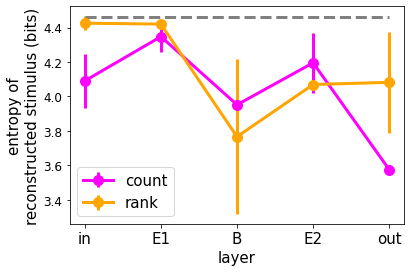

In [6]:
ent_c_mean = np.mean(ent_c_allseeds_pre,axis=0)
ent_c_sd = np.std(ent_c_allseeds_pre,axis=0)
ent_r_mean = np.mean(ent_r_allseeds_pre,axis=0)
ent_r_sd = np.std(ent_r_allseeds_pre,axis=0)
layerVec = np.arange(0,numLayers,1)
layerLabels = ['in','E1','B','E2','out']
plt.errorbar(layerVec, ent_c_mean, ent_c_sd, label='count', marker='o', linewidth=3, markersize=10, color='magenta')
plt.errorbar(layerVec, ent_r_mean, ent_r_sd, label='rank', marker='o', linewidth=3, markersize=10, color='orange')
plt.plot(layerVec,true_ent*np.ones(numLayers),color='gray',linestyle='--',linewidth=3)
plt.xticks(layerVec,layerLabels,fontsize=15)
plt.yticks(fontsize=12)
plt.ylabel('entropy of\nreconstructed stimulus (bits)',fontsize=15)
plt.xlabel('layer',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('ent_v_layer_2seeds.png',bbox_inches='tight',dpi=200)
plt.show()

TRAIN NETWORK

In [ ]:
num_iter = 100 # train for 100 iterations
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

loss_hist = [] # record loss
# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []
        
        for feature, label in train_batch:
            # prepare data
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(device)
            label = label.to(device)

            # forward pass
#             mem = model(feature)
            mem, spk_in_rec, spk_E1_rec, spk_B_rec, spk_E2_rec, spk_out_rec = model(label)
            loss_val = loss_function(mem, label) # calculate loss
            optimizer.zero_grad() # zero out gradients
            loss_val.backward() # calculate gradients
            optimizer.step() # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss) # print loss p/batch

In [ ]:
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []
        
        for feature, label in train_batch:
            # prepare data
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(device)
            label = label.to(device)

            # forward pass
#             mem = model(feature)
            mem, spk_in_rec, spk_E1_rec, spk_B_rec, spk_E2_rec, spk_out_rec = model(label)
            loss_val = loss_function(mem, label) # calculate loss
            optimizer.zero_grad() # zero out gradients
            loss_val.backward() # calculate gradients
            optimizer.step() # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss) # print loss p/batch

In [ ]:
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []
        
        for feature, label in train_batch:
            # prepare data
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(device)
            label = label.to(device)

            # forward pass
#             mem = model(feature)
            mem, spk_in_rec, spk_E1_rec, spk_B_rec, spk_E2_rec, spk_out_rec = model(label)
            loss_val = loss_function(mem, label) # calculate loss
            optimizer.zero_grad() # zero out gradients
            loss_val.backward() # calculate gradients
            optimizer.step() # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss) # print loss p/batch

In [ ]:
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []
        
        for feature, label in train_batch:
            # prepare data
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(device)
            label = label.to(device)

            # forward pass
#             mem = model(feature)
            mem, spk_in_rec, spk_E1_rec, spk_B_rec, spk_E2_rec, spk_out_rec = model(label)
            loss_val = loss_function(mem, label) # calculate loss
            optimizer.zero_grad() # zero out gradients
            loss_val.backward() # calculate gradients
            optimizer.step() # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss) # print loss p/batch

In [ ]:
plt.plot(loss_hist,color='black',linewidth=3)
plt.xlabel('iteration no.',fontsize=18)
plt.ylabel('MSE loss', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('loss_v_iter.png',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
# mem = mem.cpu()
# label = label.cpu()

plt.title("Trained Output Neuron",fontsize=18)
for i in range(batch_size):
    plt.plot(mem[:, i, :].detach().numpy(), label="Output")
    plt.plot(label[:, i, :].detach().numpy(), label="Target")
plt.xlabel("time",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("membrane potential",fontsize=18)
plt.legend(loc='best',fontsize=15)
plt.savefig('postFit.png',bbox_inches='tight',dpi=200)
plt.show()


# plt.plot(mem[:, 0, 0].cpu(), label="Output")
# plt.plot(label[:, 0, 0].cpu(), '--', label="Target")
# plt.title("Untrained Output Neuron",fontsize=18)
# plt.xlabel("time",fontsize=18)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.ylabel("membrane potential",fontsize=18)
# plt.legend(loc='best',fontsize=15)
# plt.savefig('initial_fit.png',bbox_inches='tight',dpi=200)
# plt.show()

In [ ]:
spk_in_rec = spk_in_rec.detach().numpy()
spk_E1_rec = spk_E1_rec.detach().numpy()
spk_B_rec = spk_B_rec.detach().numpy()
spk_E2_rec = spk_E2_rec.detach().numpy()
spk_out_rec = spk_out_rec.detach().numpy()

In [ ]:
spk_in_rec_re = np.reshape(spk_in_rec,(num_steps,Nin))
in_spks = np.array(spk_in_rec_re,dtype=bool)
stin, siin = np.where(in_spks == True)

spk_E1_rec_re = np.reshape(spk_E1_rec,(num_steps,NE1))
E1_spks = np.array(spk_E1_rec_re,dtype=bool)
stE1, siE1 = np.where(E1_spks == True)

spk_B_rec_re = np.reshape(spk_B_rec,(num_steps,NB))
B_spks = np.array(spk_B_rec_re,dtype=bool)
stB, siB = np.where(B_spks == True)

spk_E2_rec_re = np.reshape(spk_E2_rec,(num_steps,NE2))
E2_spks = np.array(spk_E2_rec_re,dtype=bool)
stE2, siE2 = np.where(E2_spks == True)

spk_out_rec_re = np.reshape(spk_out_rec,(num_steps,Nout))
out_spks = np.array(spk_out_rec_re,dtype=bool)
stout, siout = np.where(out_spks == True)

In [ ]:
fig, ax = plt.subplots(7,figsize=(9,12),gridspec_kw={'height_ratios': [1, 2, 8, 2, 4, 2, 1]})

for j in range(len(ax)):
#     ax[j].set_xlim([0,num_steps-1])
    ax[j].tick_params(axis='y',labelsize=12)
    if j != len(ax)-1:
        ax[j].set_xticks([])
    else:
        ax[j].tick_params(axis='x',labelsize=15)
        ax[j].set_xlabel('time (ms)',fontsize=20)
ax[0].plot(label[:, 0, 0].cpu(), color='black')
# cur_in_rec_re
ax[0].set_ylabel('s(t)',fontsize=15)
ax[1].plot(stin,siin,marker='o',linestyle='',markersize=2, color='black')
ax[1].set_ylabel('in',fontsize=18)
ax[1].set_ylim([-1,Nin+1])
ax[2].plot(stE1,siE1,marker='o',linestyle='',markersize=0.5, color='black')
ax[2].set_ylabel('E1',fontsize=18)
ax[2].set_ylim([-1,NE1+1])
ax[3].plot(stB,siB,marker='o',linestyle='',markersize=2, color='black')
ax[3].set_ylabel('B',fontsize=18)
ax[3].set_ylim([-1,NB+1])
ax[4].plot(stE2,siE2,marker='o',linestyle='',markersize=1, color='black')
ax[4].set_ylim([-1,NE2+1])
ax[4].set_ylabel('E2',fontsize=18)
ax[5].plot(stout,siout,marker='o',linestyle='',markersize=2, color='black')
ax[5].set_ylabel('out',fontsize=18)
ax[5].set_ylim([-1,Nout+1])
ax[6].set_ylabel('volts',fontsize=15)
ax[6].plot(mem[:, 0, :].detach().numpy(), color='black')

plt.savefig('raster_postTrain.png',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
layerNames = ['in', 'E1', 'B', 'E2', 'out']
N_nrnVec = [Nin, NE1, NB, NE2, Nout]
allSpikeTimes = [stin, stE1, stB, stE2, stout]
allSpikeIndices = [siin, siE1, siB, siE2, siout]
numLayers = len(layerNames)

tf = num_steps
T_R = 50
train_frac = 0.5
slideVec = np.arange(0,tf-T_R+dt,dt)
num_times = len(slideVec)
stimSub = label[:, 0, :][:num_times]
tvecSub = tvec[:num_times]
y = np.array(stimSub)
y = np.reshape(y,(len(y),))
stim = y

r2_tr_c_all = []
r2_te_c_all = []
r2_tr_r_all = []
r2_te_r_all = []
mi_c_all = []
mi_r_all = []
ent_c_all = []
ent_r_all = []

tag = 'postTrain'
path = tag

for li in range(numLayers):
    layerName = layerNames[li]
    print(layerName)
    N_nrn = N_nrnVec[li]
    st = allSpikeTimes[li]
    si = allSpikeIndices[li]
    
    fitMetrics, data = getCorrPlots(st,si,stim,N_nrn,tf,T_R,dt,delta_t,
                                            seednum,delay,layerName,tag)
    r2_tr_c, r2_te_c, r2_tr_r, r2_te_r, mi_c, mi_r = fitMetrics
    y_test, y_pred_count, y_pred_rank = data
    getReconstruction(tvecSub,y_test,y_pred_count,y_pred_rank,layerName,tag)
    true_ent, count_ent, rank_ent = getStimDist(y_test,y_pred_count,y_pred_rank,layerName,tag)
    
    r2_tr_c_all.append(r2_tr_c)
    r2_te_c_all.append(r2_te_c)
    r2_tr_r_all.append(r2_tr_r)
    r2_te_r_all.append(r2_te_r)
    mi_c_all.append(mi_c)
    mi_r_all.append(mi_r)
    ent_c_all.append(count_ent)
    ent_r_all.append(rank_ent)
    

In [ ]:
layerVec = np.arange(0,numLayers,1)
layerLabels = ['in','E1','B','E2','out']
plt.plot(layerVec,r2_te_c_all,label='count',marker='o',linewidth=3,markersize=10,color='magenta')
plt.plot(layerVec,r2_te_r_all,label='rank',marker='o',linewidth=3,markersize=10,color='orange')
plt.plot(layerVec,np.zeros(numLayers),color='gray',linestyle='--',linewidth=3)
plt.xticks(layerVec,layerLabels,fontsize=15)
plt.yticks(fontsize=12)
plt.ylabel(r'decoding accuracy $R^2$',fontsize=15)
plt.xlabel('layer',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('R2_v_layer.png',bbox_inches='tight',dpi=200)
plt.show()